#Spectral clustering

Spectral clustering uses the **eigenvalues and eigenvectors** of the graph's **Laplacian matrix** to reduce the dimensionality of the data and then applies clustering (e.g., KMeans) on the reduced representation.

This technique is particularly useful for identifying **non-linearly separable clusters** in graph-structured data.

---

## 📌 Steps Involved:

### 1. Load the Graph Data
- Reads the nodes (papers) with their **features** and **labels** from `cora.content`.
- Reads the edges (citations between papers) from `cora.cites`.

---

### 2. Build the Graph
- Constructs an undirected graph using **NetworkX**, where:
  - Nodes = papers
  - Edges = citation links between papers

---

### 3. Compute the Graph Laplacian
- Builds the **adjacency matrix** and the **degree matrix**.
- Computes the **normalized symmetric Laplacian**:
  $$
  L_{sym} = I - D^{-1/2} A D^{-1/2}
  $$

---

### 4. Compute Eigenvectors
- Finds the **first $k$ smallest eigenvectors** of the Laplacian matrix:
  $$
  L_{sym} \mathbf{v} = \lambda \mathbf{v}
  $$
- These eigenvectors form the **spectral embedding** (low-dimensional representation) of the graph nodes.

---

### 5. Cluster Using KMeans
- Applies the **KMeans** clustering algorithm to the spectral embedding (i.e., the eigenvectors).
- Each node is assigned to a cluster.

---

### 6. Visualize the Clustering
- Uses **PCA** and optionally **t-SNE** to reduce the spectral embeddings to 2D.
- Plots the resulting 2D points colored by their assigned **cluster labels**.

---

This approach captures both **global structure** and **local neighborhood relationships**, making it especially effective for **community detection** and **graph-based clustering tasks**.




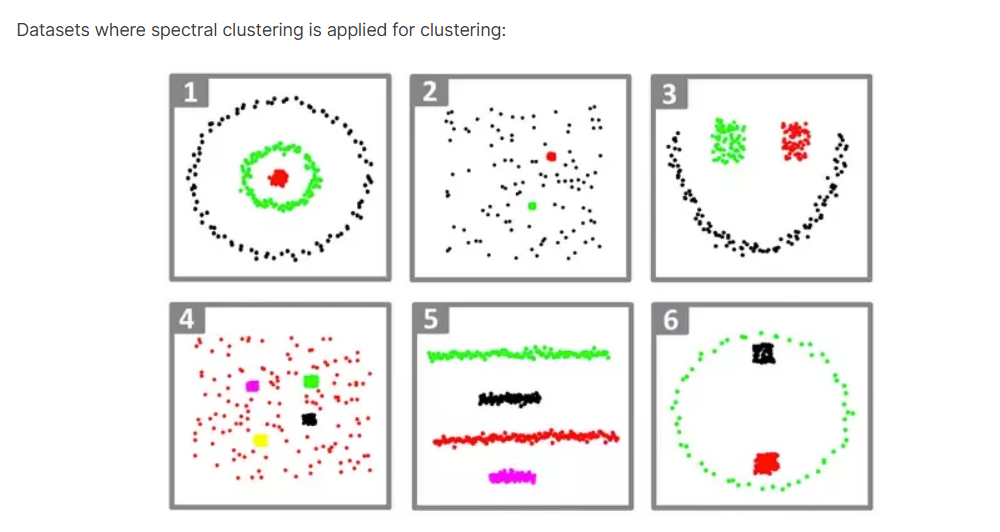

## Lets see an example on moon dataset:


In [13]:
import numpy as np
from scipy.linalg import eigh
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt

In [14]:
# Create the dataset
X, y = make_moons(n_samples=300, noise=0.1, random_state=42)

In [15]:
def rbf_kernel(X, gamma=1.0):
    pairwise_sq_dists = np.sum((X[:, np.newaxis] - X[np.newaxis, :]) ** 2, axis=2)
    return np.exp(-gamma * pairwise_sq_dists)

# Compute the similarity matrix
similarity_matrix = rbf_kernel(X, gamma=15.0)

In [16]:
# Degree matrix
degree_matrix = np.diag(similarity_matrix.sum(axis=1))

# Laplacian matrix
laplacian_matrix = degree_matrix - similarity_matrix

In [17]:
# Compute the eigenvalues and eigenvectors
eigenvalues, eigenvectors = eigh(laplacian_matrix)

# Select the eigenvectors corresponding to the smallest k eigenvalues
k = 2
selected_eigenvectors = eigenvectors[:, :k]

In [18]:
from sklearn.cluster import KMeans

# Perform k-means clustering
kmeans = KMeans(n_clusters=k)
kmeans.fit(selected_eigenvectors)
labels = kmeans.labels_

In [20]:
# evaluate NMI and ARI

from sklearn.metrics.cluster import normalized_mutual_info_score, adjusted_rand_score

nmi = normalized_mutual_info_score(y, labels)
ari = adjusted_rand_score(y, labels)

print(f"NMI: {nmi}")
print(f"ARI: {ari}")


NMI: 0.7137512794665284
ARI: 0.809362444539531


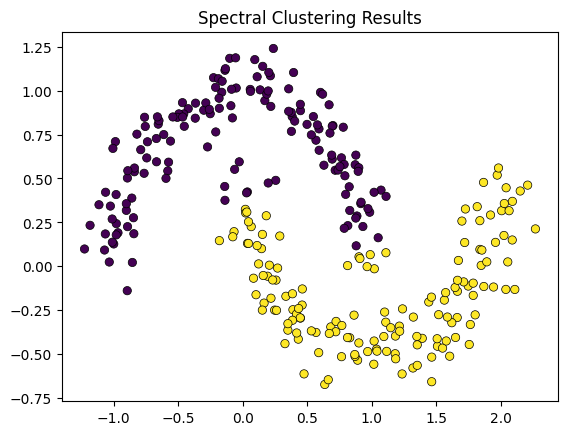

In [19]:
# Plot the results
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', lw=0.5, edgecolor='k')
plt.title("Spectral Clustering Results")
plt.show()

#Another example on the Cora dataset

## 📦 Library Imports

This section imports the necessary Python libraries used throughout the notebook:

- **`numpy`**: For numerical operations, especially matrix operations like eigen decomposition.
- **`pandas`**: For loading and manipulating tabular data (e.g., reading CSV files like `cora.content` and `cora.cites`).
- **`networkx`**: For creating and managing the graph structure (nodes and edges).
- **`sklearn.cluster.KMeans`**: For performing the **KMeans clustering algorithm** on the spectral embeddings.
- **`sklearn.decomposition.PCA`** and **`sklearn.manifold.TSNE`**:
  - For reducing the dimensionality of the high-dimensional spectral data (eigenvectors) into 2D for **visualization**.
- **`scipy.linalg.eigh`**: For computing **eigenvalues** and **eigenvectors** of a symmetric matrix (specifically the Laplacian matrix).
- **`matplotlib.pyplot`**: For plotting and visualizing clusters in 2D space.
- **`warnings`**: To manage and suppress potential warnings (e.g., deprecation or future warnings from libraries like `sklearn`).

These libraries form the core toolset for performing **spectral clustering** and analyzing **graph-based datasets**.


In [1]:
import numpy as np
import pandas as pd
import networkx as nx
from sklearn.cluster import KMeans
# Import t-SNE as an alternative visualization tool
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from scipy.linalg import eigh # Use eigh for dense matrices
import matplotlib.pyplot as plt
import warnings

# Suppress KMeans future warning about n_init
warnings.filterwarnings("ignore", message="The default value of `n_init` will change from 10 to 'auto' in 1.4.", category=FutureWarning)

## 📄 Loading the `cora.content` File

This part of the code loads the `cora.content` file using **pandas**, which contains detailed information about each paper (node) in the graph:

- **Each row** in the file corresponds to a paper.
- The columns contain:
  - A **unique paper ID** (column 0)
  - A **feature vector** (columns 1 to 1433) indicating the presence of specific words in the paper
  - A **subject label** (last column), which represents the ground truth category or topic of the paper


In [2]:
# Step 1: Load content
content = pd.read_csv("cora.content", sep="\t", header=None)
features = content.iloc[:, 1:-1].values
paper_ids = content[0].values
labels = content.iloc[:, -1].values

# Step 2: Map paper_ids to indices
id_to_index = {paper_id: idx for idx, paper_id in enumerate(paper_ids)}

In [3]:
# Step 3: Load citation edges and build graph
edges = pd.read_csv("cora.cites", sep="\t", header=None)
edges = edges[edges[0].isin(id_to_index) & edges[1].isin(id_to_index)]
edge_indices = [(id_to_index[row[0]], id_to_index[row[1]]) for row in edges.values]

G = nx.Graph()
G.add_nodes_from(range(len(paper_ids)))
G.add_edges_from(edge_indices)

##Graph Laplacian

In [4]:
# Step 4: Create adjacency matrix and compute Laplacian
# Ensure A is dense for eigh
A = nx.adjacency_matrix(G).toarray().astype(float)
# D is the diagonal degree matrix
D = np.diag(A.sum(axis=1))
L = D - A # Unnormalized Laplacian

In [5]:
# Step 5: Normalized symmetric Laplacian
# Compute D_inv_sqrt carefully, handling potential division by zero for isolated nodes
degree_sum = A.sum(axis=1)
D_inv_sqrt = np.diag(1.0 / np.sqrt(np.maximum(degree_sum, 1e-10))) #computes the inverse square root of the degree matrix, Use 1e-10 for stability
L_sym = np.eye(A.shape[0]) - D_inv_sqrt @ A @ D_inv_sqrt #computes the normalized symmetric Laplacian

##Compute Eigenvectors

In [6]:
# Step 6: Compute first k eigenvectors (smallest k non-zero)
k = 7  # number of clusters
# eigh returns eigenvalues in ascending order by default.
# subset_by_index=(0, k - 1) gives the first k smallest eigenvalues/vectors.
# For the normalized Laplacian L_sym, the smallest eigenvalue is 0 with eigenvector of all 1s.
# We typically want the next k eigenvectors for clustering.
# So, we select eigenvectors corresponding to eigenvalues from index 1 to k.
# NOTE: Some definitions use the first k *non-zero* eigenvectors, which would be indices 1 to k.
# The original code used 0 to k-1. Let's stick to 0 to k-1 as in the original.
# If you need the *first k non-zero* eigenvectors, change subset_by_index to (1, k).
eigvals, eigvecs = eigh(L_sym, subset_by_index=(0, k - 1))

## KMeans Clustering

In [11]:
# Step 7: KMeans clustering on eigenvectors
# KMeans clusters in the k-dimensional space of the eigenvectors
# Using 'auto' for n_init is recommended in newer sklearn versions
kmeans = KMeans(n_clusters=k, n_init='auto', random_state=42)
cluster_labels = kmeans.fit_predict(eigvecs)

In [12]:
#evaluate NMI and ARI

from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score

# Evaluate clustering performance using NMI and ARI
# Assuming 'labels' are the true labels and 'cluster_labels' are the predicted cluster assignments
nmi = normalized_mutual_info_score(labels, cluster_labels)
ari = adjusted_rand_score(labels, cluster_labels)

print(f"Normalized Mutual Information (NMI): {nmi:.4f}")
print(f"Adjusted Rand Index (ARI): {ari:.4f}")


Normalized Mutual Information (NMI): 0.0098
Adjusted Rand Index (ARI): -0.0015


##Visualization

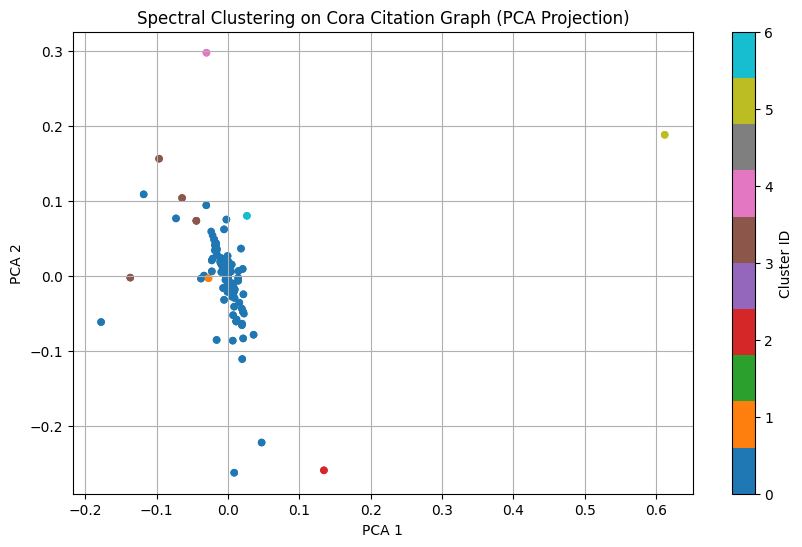

In [8]:
# Step 8: Visualize the clustering
# We can use either PCA or t-SNE for 2D projection for visualization

# Option 1: Visualize using PCA
pca = PCA(n_components=2, random_state=42)
projected_pca = pca.fit_transform(eigvecs)

plt.figure(figsize=(10, 6))
scatter_pca = plt.scatter(projected_pca[:, 0], projected_pca[:, 1], c=cluster_labels, cmap='tab10', s=20)
plt.title("Spectral Clustering on Cora Citation Graph (PCA Projection)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.colorbar(scatter_pca, label='Cluster ID')
plt.grid(True)
plt.show()

/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


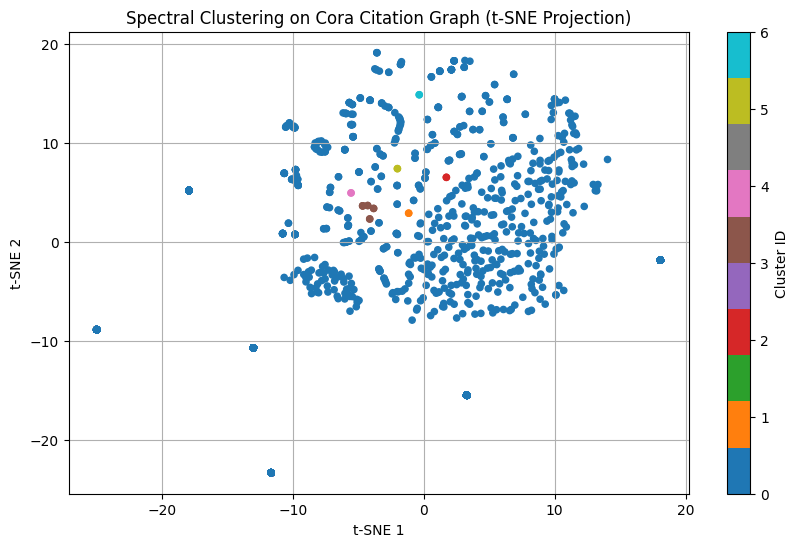

In [ ]:
# Option 2: Visualize using t-SNE
# t-SNE is often better at revealing clusters but is computationally more expensive
# perplexity and learning_rate are key parameters, often require tuning
# n_iter is the number of iterations
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=300)
# t-SNE is sensitive to initial scale, it's common to normalize the data first
# eigvecs are already somewhat scaled by the eigendecomposition, but normalization can help
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
eigvecs_scaled = scaler.fit_transform(eigvecs)

projected_tsne = tsne.fit_transform(eigvecs_scaled) # Fit t-SNE on scaled eigenvectors

plt.figure(figsize=(10, 6))
scatter_tsne = plt.scatter(projected_tsne[:, 0], projected_tsne[:, 1], c=cluster_labels, cmap='tab10', s=20)
plt.title("Spectral Clustering on Cora Citation Graph (t-SNE Projection)")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.colorbar(scatter_tsne, label='Cluster ID')
plt.grid(True)
plt.show()

#Do for the DBLP Dataset yourself

More info on dataset: https://snap.stanford.edu/data/com-DBLP.html

In [ ]:
import numpy as np
import pandas as pd
import networkx as nx
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from scipy.sparse.linalg import eigsh # Import sparse eigenvector solver
from scipy.sparse import identity as sparse_eye, diags as sparse_diags # Import sparse matrix utilities
import matplotlib.pyplot as plt
import warnings

# Suppress KMeans future warning about n_init
warnings.filterwarnings("ignore", message="The default value of `n_init` will change from 10 to 'auto' in 1.4.", category=FutureWarning)

# Define the path to the graph file
graph_file_path = "com-dblp.ungraph.txt"

# Step 1: Load the graph from the edge list file
# The file typically contains edges, with lines starting with '#' being comments
print(f"Loading graph from {graph_file_path}...")
edges = []
# Read edges line by line, skipping comments
with open(graph_file_path, 'r') as f:
    for line in f:
        if line.startswith('#'):
            continue # Skip comment lines
        # Edges are space or tab separated integers
        u, v = map(int, line.split())
        edges.append((u, v))

G = nx.Graph()
# Add nodes and edges
# Using the raw IDs from the file
G.add_edges_from(edges)

print(f"Graph loaded: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")

# Step 2: Create Adjacency Matrix and Compute Laplacian (Sparse Method)
# NetworkX returns a sparse matrix for adjacency matrix by default, which is needed for large graphs
A = nx.adjacency_matrix(G) # A is a sparse matrix (e.g., csr_matrix)

# Compute the degree of each node
# A.sum(axis=1) on a sparse matrix returns a sparse matrix (column vector)
degree = A.sum(axis=1)

# Convert the sparse degree vector to a dense numpy array for calculations
degree_arr = np.array(degree).flatten()

# Compute the diagonal matrix D (sparse)
# Use sparse_diags to create a sparse diagonal matrix from the degree array
D = sparse_diags(degree_arr)

# Compute the Unnormalized Laplacian L = D - A (sparse)
L = D - A

# Step 3: Compute Normalized Symmetric Laplacian (Sparse Method)
# Compute D_inv_sqrt as a sparse diagonal matrix
# Handle nodes with degree 0 (isolated nodes) to avoid division by zero
degree_inv_sqrt_diag = np.zeros_like(degree_arr)
non_zero_degree_mask = degree_arr > 1e-10 # Use a small epsilon for robustness
degree_inv_sqrt_diag[non_zero_degree_mask] = 1.0 / np.sqrt(degree_arr[non_zero_degree_mask])

D_inv_sqrt = sparse_diags(degree_inv_sqrt_diag)

# Compute the Normalized Symmetric Laplacian: L_sym = I - D_inv_sqrt @ A @ D_inv_sqrt (sparse)
I = sparse_eye(A.shape[0]) # Sparse identity matrix
L_sym = I - D_inv_sqrt @ A @ D_inv_sqrt

print("Laplacian computed (sparse).")

# Step 4: Compute first k eigenvectors using eigsh (for sparse matrices)
# Note: For sparse Laplacian, eigsh is required.
# 'SM' requests the smallest magnitude eigenvalues.
# We need k eigenvectors for clustering. The smallest eigenvalue is often 0 (corresponding to the constant vector).
# Depending on the definition, we might want the first k *non-zero* eigenvectors (indices 1 to k)
# or the first k *smallest* eigenvectors including the zero one (indices 0 to k-1).
# The original Cora code used 0 to k-1. Let's use that here.
k = 10 # Choose a number of clusters (e.g., 10) - DBLP communities are not fixed at 7
print(f"Computing first {k} eigenvectors using eigsh...")
try:
    # eigsh returns eigenvalues in ascending order by default for 'SM'
    eigvals, eigvecs = eigsh(L_sym, k=k, which='SM')
    print("Eigenvectors computed.")
    # eigvecs shape will be (num_nodes, k)
    # Note: eigsh might return eigenvectors scaled differently than eigh, but this doesn't affect KMeans.
except Exception as e:
    print(f"Error during eigsh computation: {e}")
    print(" eigsh might fail for very disconnected graphs or other numerical issues.")
    print(" Consider checking graph connectivity or reducing k.")
    exit() # Exit if eigenvector computation fails


# Step 5: Cluster using KMeans on the eigenvectors
# KMeans will cluster the nodes based on their position in the k-dimensional eigenvector space
print(f"Performing KMeans clustering with k={k}...")
kmeans = KMeans(n_clusters=k, n_init='auto', random_state=42)
cluster_labels = kmeans.fit_predict(eigvecs)
print("Clustering complete.")

# Step 6: Visualize the clustering in 2D (projected)
# We don't have true labels, so we can only visualize the predicted clusters
print("Projecting eigenvectors to 2D using PCA for visualization...")
pca = PCA(n_components=2, random_state=42)
projected = pca.fit_transform(eigvecs)
print("Projection complete.")

plt.figure(figsize=(10, 8)) # Slightly larger figure for more points
scatter = plt.scatter(projected[:, 0], projected[:, 1], c=cluster_labels, cmap='tab20', s=5, alpha=0.6) # Use tab20 for more colors if k>10, smaller points for many nodes
plt.title(f"Spectral Clustering on DBLP Graph (PCA Projection, k={k})")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.colorbar(scatter, label='Predicted Cluster ID')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# Note: We cannot perform clustering evaluation metrics (like ARI, NMI)
# or plot with true labels as they are not available in this dataset file.